In [1]:
%matplotlib inline
import scipy
from scipy import special
import PyDSTool as dst
import numpy as np
from matplotlib import pyplot as plt
import pandas
import scipy.io as si
import brian2

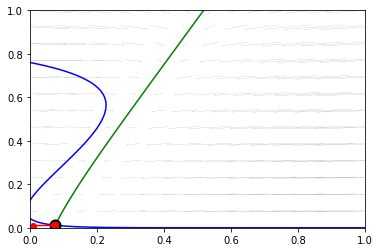

In [7]:
DSargs = dst.args(name='E-I_model')

# parameters
DSargs.pars = { 'tau_NMDA': 0.06,
                'tau_GABA': 0.005,
                'a_E': 270.,
                'b_E': 108.,
                'd_E': 0.154,
                'a_I': 615,
                'b_I': 177,
                'd_I': 0.087,
                'gam': 0.641,
                'g_Eself': 0.52,
                'g_IE':   0.25,
                'g_EI': -0.35,
                'g_Iself': -0.2,
                'I_0': 0.31,
                'I_ext': 0}

# auxiliary functions: fI curve and recurrent current
DSargs.fnspecs  = {
    'fI_E': (['I'], '(a_E*I-b_E)/(1.0 - exp(-d_E*(a_E*I-b_E)))'),
    'fI_I': (['I'], '(a_I*I-b_I)/(1.0 - exp(-d_I*(a_I*I-b_I)))'),
    'recCurrE': (['x', 'y'], 'g_Eself*x + g_EI*y + I_0'),
    'recCurrI': (['x', 'y'], 'g_Iself*x + g_IE*y + I_0')
}

# rhs of the differential equations
DSargs.varspecs = {'S_NMDA': '(-S_NMDA/tau_NMDA + gam*(1.0 - S_NMDA)*fI_E(recCurrE(S_NMDA,S_GABA) + I_ext))',
                   'S_GABA': ' -S_GABA/tau_GABA + fI_I(recCurrI(S_GABA,S_NMDA))'}

# initial conditions
DSargs.ics = {'S_NMDA': 0.01, 'S_GABA': 0.01}

# set the range of integration
DSargs.tdomain = [0,10]

# variable domain for the phase plane analysis
DSargs.xdomain = {'S_GABA': [0.0,1.0], 'S_NMDA': [0.0,1.0]}

# variable domain for the phase plane analysis
DSargs.pdomain = {'I_ext': [0,0.3] }

# Create the model object
dmModel = dst.Vode_ODEsystem(DSargs)

# Open a figure and plot the vector field
from PyDSTool.Toolbox import phaseplane as pp

pp.plot_PP_vf(dmModel,'S_GABA','S_NMDA',N=14, scale_exp=-1)

# Find the fixed points
fp_coord = pp.find_fixedpoints(dmModel, n=12)

# # Find and plot the nullclines
nulls_x, nulls_y = pp.find_nullclines(dmModel, 'S_NMDA', 'S_GABA', n=3, eps=1e-8,max_step=0.01,fps=fp_coord)

plt.plot(nulls_x[:,1], nulls_x[:,0],'b')
plt.plot(nulls_y[:,1], nulls_y[:,0],'g')

# Compute the jacobian to determine the stability of the fixed points
jac, new_fnspecs = \
dst.prepJacobian(dmModel.funcspec._initargs['varspecs'],
['S_GABA', 'S_NMDA'], dmModel.funcspec._initargs['fnspecs'])
scope = dst.copy(dmModel.pars)
scope.update(new_fnspecs)
jac_fn = dst.expr2fun(jac, ensure_args=['t'], **scope)

# add fixed points to the phase portrait

for i in range(0,len(fp_coord)):
    fp = pp.fixedpoint_2D(dmModel,dst.Point(fp_coord[i]),
                         jac = jac_fn, eps=1e-8)
    pp.plot_PP_fps(fp)

# compute an example trajectory
traj = dmModel.compute('trajectory1')
pts = traj.sample()
plt.plot(pts['S_GABA'],pts['S_NMDA'],'r-o')

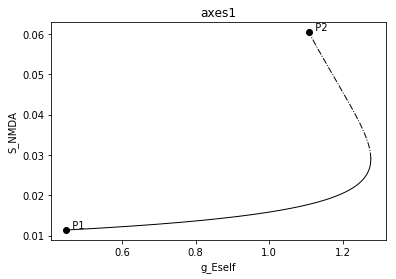

In [8]:
# Set the lower bound of the control (bifurcation) parameter
dmModel.set(pars = {'g_Eself': 0.45})

# initial conditions # Close to one of the steady states
dmModel.set(ics = {'S_NMDA': 0.01, 'S_GABA': 0.01})

# Set up continuation class
PC = dst.ContClass(dmModel)

# Equilibrium point curve (EP-C). The branch is labeled EQ1:
PCargs = dst.args(name='EQ1', type='EP-C')
PCargs.freepars = ['g_Eself'] # control parameter
PCargs.MaxNumPoints = 1000
PCargs.MaxStepSize  = 1e-4
PCargs.MinStepSize  = 1e-5
PCargs.StepSize     = 1e-3
PCargs.LocBifPoints = ['all'] #['LP','BP']   # detect limit and saddle-node bifurcation types
PCargs.SaveEigen = True # to determine the stability of branches

PC.newCurve(PCargs)

PC['EQ1'].forward()

PC['EQ1'].display(['g_Eself','S_NMDA'], stability=True, figure=1)